In [1]:
from tqdm import tqdm
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForMaskedLM, AutoModelForCausalLM
from sklearn.linear_model import LogisticRegression

from ccs_model import CCS
from ccs_utils import *

/home/asuka/anaconda3/envs/llm/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2


In [ ]:
def get_model_and_data(model_name="deberta", cache_dir=None, save_path=None, n=2000):
    # Let's just try IMDB for simplicity
    data = load_dataset("amazon_polarity")["test"]

    if model_name == "deberta":
        model_type = "encoder"
        tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v2-xxlarge", cache_dir=cache_dir)
        model = AutoModelForMaskedLM.from_pretrained("microsoft/deberta-v2-xxlarge", cache_dir=cache_dir)
        model.cuda()
    elif model_name == "gpt-j":
        model_type = "decoder"
        tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B", cache_dir=cache_dir)
        model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-j-6B", cache_dir=cache_dir)
        model.cuda()
    elif model_name == "t5":
        model_type = "encoder_decoder"
        tokenizer = AutoTokenizer.from_pretrained("t5-11b", cache_dir=cache_dir)
        model = AutoModelForSeq2SeqLM.from_pretrained("t5-11b", cache_dir=cache_dir)
        model.parallelize()  # T5 is big enough that we may need to run it on multiple GPUs
    else:
        raise ValueError(f"Model {model_name} not implemented!")

    neg_hs, pos_hs, y = get_hidden_states_many_examples(model, tokenizer, data, model_type, n=n)
    
    # Save the processed data to a single file
    np.savez(save_path, neg_hs=neg_hs, pos_hs=pos_hs, y=y)
    
    return neg_hs, pos_hs, y


def validate(neg_hs, pos_hs, y):
    # let's create a simple 50/50 train split (the data is already randomized)
    n = len(y)
    neg_hs_train, neg_hs_test = neg_hs[:n//2], neg_hs[n//2:]
    pos_hs_train, pos_hs_test = pos_hs[:n//2], pos_hs[n//2:]
    y_train, y_test = y[:n//2], y[n//2:]

    # for simplicity we can just take the difference between positive and negative hidden states
    # (concatenating also works fine)
    x_train = neg_hs_train - pos_hs_train
    x_test = neg_hs_test - pos_hs_test

    lr = LogisticRegression(class_weight="balanced")
    lr.fit(x_train, y_train)
    print("Logistic regression accuracy: {}".format(lr.score(x_test, y_test)))
    
    return neg_hs_train, neg_hs_test, pos_hs_train, pos_hs_test, y_train, y_test


def eval_css(neg_hs_train, neg_hs_test, pos_hs_train, pos_hs_test, y_train, y_test):
    # Train CCS without any labels
    ccs = CCS(neg_hs_train, pos_hs_train)
    ccs.repeated_train()

    # Evaluate
    ccs_acc = ccs.get_acc(neg_hs_test, pos_hs_test, y_test)
    print("CCS accuracy: {}".format(ccs_acc))

    # Train CCS with labels
    ccs_supervised = CCS(neg_hs_train, pos_hs_train)
    ccs_supervised.supervised_train(y_train, batch_size=32, verbose=False, nepochs=50)
    ccs_supervised.repeated_train()

    # Evaluate
    ccs_supervised_acc = ccs_supervised.get_acc(neg_hs_test, pos_hs_test, y_test)
    print("CCS supervised accuracy: {}".format(ccs_supervised_acc))

: 

In [ ]:
model_name = 'gpt-j'

data_file = f'data/{model_name}.npz'
# Load data otherwise download and process data
try:
    data = np.load(data_file)
    neg_hs = data['neg_hs']
    pos_hs = data['pos_hs']
    y = data['y']
except FileNotFoundError:
    # If the file doesn't exist, process the data
    neg_hs, pos_hs, y = get_model_and_data(model_name=f"{model_name}", cache_dir=None, n=2)

# Validate the data
neg_hs_train, neg_hs_test, pos_hs_train, pos_hs_test, y_train, y_test = validate(neg_hs, pos_hs, y)

Found cached dataset parquet (/home/asuka/.cache/huggingface/datasets/parquet/amazon_polarity-d48d00b6869479db/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


CCS accuracy: 0.92
First 5 x values: tensor([[ 0.4579,  0.3842,  0.0718,  ..., -0.1573,  0.1860,  0.0675],
        [-0.1846,  0.1623, -0.2492,  ...,  0.0315,  0.2465,  0.1014],
        [ 0.0493,  0.1822, -0.1704,  ...,  0.0660, -0.1891, -0.2362],
        [ 0.0234,  0.4391,  0.2915,  ...,  0.0321, -0.0934,  0.0675],
        [ 0.2578,  0.2625, -0.0418,  ...,  0.0118, -0.1849,  0.1015]],
       device='cuda:0')
First 5 y values: tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0')
Shape of x: torch.Size([100, 1536])
Shape of y: torch.Size([100, 1])
Unique y values: tensor([0., 1.], device='cuda:0')
Distribution of y values: tensor([58, 42], device='cuda:0')
100 32 3


100%|██████████| 50/50 [00:00<00:00, 371.57it/s]


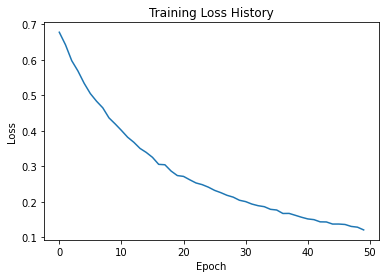

CCS supervised accuracy: 0.92


In [ ]:
# Evaluate CCS
eval_css(neg_hs_train, neg_hs_test, pos_hs_train, pos_hs_test, y_train, y_test)